In [ ]:
import numpy as np
import sklearn
import sklearn.datasets
import csv

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

def construct_time_windows(x, desire, order):

  N = order # ORDER OF THE FILTERS

  x_list = []
  label_list = []
  DESIRE = []

  desire_windows = []

  for i in range(N-1, len(x)):
      x_list.append(x[i-N+1:i+1])
      label_list.append(desire[i])

  x_list = np.array(x_list)
  label_list = np.array(label_list)

  return x_list, label_list

def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

# FRIEDMAN #1
def generate_F1():
  x, desire = sklearn.datasets.make_friedman1(20000)
  return x, desire

# FRIEDMAN #2
def generate_F2():
  x, desire = sklearn.datasets.make_friedman2(20000)
  return x, desire

# FRIEDMAN #3
def generate_F3():
  x, desire = sklearn.datasets.make_friedman3(20000)
  return x, desire

# CALIFORNIA HOUSING
def generate_CH():
  x = sklearn.datasets.fetch_california_housing()['data']
  desire = sklearn.datasets.fetch_california_housing()['target']
  return x, desire

# BOSTON HOUSING
def generate_BH():
  x = sklearn.datasets.load_boston()['data']
  desire = sklearn.datasets.load_boston()['target']
  return x, desire

# DIABETES
def generate_DB():
  x = sklearn.datasets.load_diabetes()['data']
  desire = sklearn.datasets.load_diabetes()['target']
  return x, desire

# FREQUENCY DOUBLER
def generate_FD(order = 3):
  i = np.linspace(0, 24*np.pi, 1200)
  x = np.sin(i)
  x = x/np.std(x)
  desire = np.sin(2*i)
  desire = desire/np.std(desire)
  x, desire = construct_time_windows(x, desire, order)
  return x, desire

# LORENZ SYSTEM
def generate_LORENZ(order = 10):
  dt = 0.01
  num_steps = 20000
  xs = np.empty(num_steps + 1)
  ys = np.empty(num_steps + 1)
  zs = np.empty(num_steps + 1)
  xs[0], ys[0], zs[0] = (0., 1., 1.05)
  for i in range(num_steps):
      x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
      xs[i + 1] = xs[i] + (x_dot * dt)
      ys[i + 1] = ys[i] + (y_dot * dt)
      zs[i + 1] = zs[i] + (z_dot * dt)

  x = ys
  desire = zs
  x, desire = construct_time_windows(x, desire, order)
  return x, desire

# LASER DATASET
def generate_LASER(order = 10):
  data = np.genfromtxt('./drive/MyDrive/ts_dataset/santafelaser.csv')
  x, desire = construct_time_windows(data[:-1], data[1:], order)
  return x, desire

# SUNSPOT
def generate_SUN(order = 10):
  SN_list_ = []
  with open('./drive/MyDrive/SN_m_tot_V2.0.txt', 'r') as fd:
    reader = csv.reader(fd)
    for row in reader:
      SN_list = []
      list_ = row[0].split(' ')
      for number in list_:
        try: SN_list.append(float(number))
        except: continue
      SN_list_.append(np.array(SN_list, dtype='float32'))

  data = np.stack(SN_list_)[:, 3]
  x, desire = construct_time_windows(data[:-1], data[1:], order)
  return x, desire

# CO2
def generate_CO2(order = 10):
  co2_list_ = []
  with open('./drive/MyDrive/co2_mm_gl.txt', 'r') as fd:
    reader = csv.reader(fd)
    for row in reader:
      co2_list = []
      list_ = row[0].split(' ')
      for number in list_:
        try: co2_list.append(float(number))
        except: continue
      if len(co2_list) == 5:
        co2_list_.append(np.array(co2_list, dtype='float32'))
  data = np.stack(co2_list_)[:, 3]
  x, desire = construct_time_windows(data[:-1], data[1:], order)
  return x, desire


In [ ]:
class NETWORK_F_MLP(nn.Module):
    def __init__(self, input_dim = 784, HIDDEN = 200, out_dim = 200, how_many_layers = 2):
        super(NETWORK_F_MLP, self).__init__()
        self.dim = out_dim
        self.many_layer = how_many_layers

        self.fc_list = []
        self.bn_list = []

        self.fc_list.append(nn.Linear(input_dim+20, HIDDEN, bias=True))
        self.bn_list.append(nn.BatchNorm1d(HIDDEN))

        for i in range(0, self.many_layer-1):
            self.fc_list.append(nn.Linear(HIDDEN, HIDDEN, bias=True))
            self.bn_list.append(nn.BatchNorm1d(HIDDEN))

        self.fc_list = nn.ModuleList(self.fc_list)
        self.bn_list = nn.ModuleList(self.bn_list)

        self.fc_final = nn.Linear(HIDDEN, out_dim, bias=True)

    def forward(self, x):

        same_noise = torch.zeros((x.shape[0], 20)).uniform_().cuda()
        x = torch.cat((x, same_noise), 1)

        for i in range(0, self.many_layer):

            x = self.fc_list[i](x)
            x = torch.relu(x)
            x = self.bn_list[i](x)

#         same_noise = torch.zeros((x.shape[0], 100)).uniform_().cuda()
#         x = torch.cat((x, same_noise), 1)

        x = torch.sigmoid((self.fc_final(x)))
        return x

def adaptive_estimation(v_t, beta, square_term, i):
    v_t = beta*v_t + (1-beta)*square_term.detach()
    return v_t, (v_t/(1-beta**i))

def print_f_eigenvector_mnist():

    input_ = torch.from_numpy(train_data[::10])

    BS = 1
    output_f = np.zeros((BS, input_.shape[0], units_f))
    for k in range(0, BS):
        output_f[k] = NET_F(input_.cuda().float()).detach().cpu().numpy()
    output_f = output_f.mean(0)
    var_f = output_f.var(0)

#     plt.plot(output_f[::10])
#     plt.show()

    normalized_f = output_f
#     normalized_f = output_f - output_f.mean(0)
    normalized_f = normalized_f@normalize_fmp[:units_f, :units_f]

#     normalized_f = normalized_f.reshape(10, 10, 10).mean(1)

    grad_matrix = grad[:units_f, units_f:]@grad[:units_f, units_f:].T

    # grad_matrix = np.linalg.inv(grad_matrix)
    eig = np.abs(np.linalg.eig(grad_matrix)[0])
    eig_vec = np.linalg.eig(grad_matrix)[1]

    constructed_value = eig
    constructed_vector = (eig_vec.T@normalized_f.T).T

    return constructed_vector, constructed_value

In [ ]:
def produce_CC_GRAD_ALL(cat_vector, track_cov, i):
#     XY = cat_vector.T@cat_vector/cat_vector.shape[0] - cat_vector.mean(0).unsqueeze(1)@cat_vector.mean(0).unsqueeze(0)
    XY = cat_vector.T@cat_vector/cat_vector.shape[0]
    cov = XY + torch.eye((XY.shape[0])).cuda()*(0.01)

    track_cov, cov_estimate = adaptive_estimation(track_cov, 0.9, cov, i)
    return cov_estimate, cov, track_cov

In [ ]:
import csv
from sklearn import svm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from sklearn.linear_model import LinearRegression

import sklearn
from sklearn import datasets

# In = np.loadtxt('sun_spot_input.asc')

train_data, desired = generate_LORENZ(order = 10)

In [ ]:
SAMPLE_X = torch.from_numpy(train_data)
SAMPLE_Y = torch.from_numpy(desired).reshape(-1, 1)

1 -7.3484954833984375


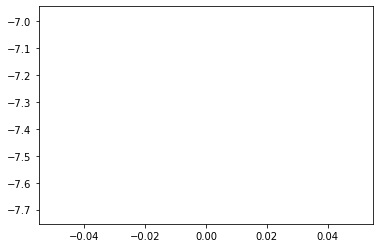

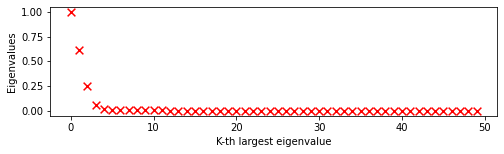

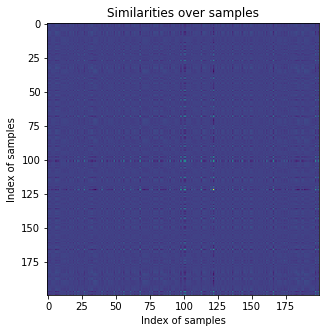

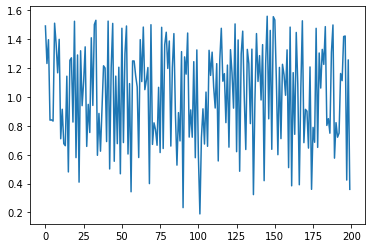

11.499922392636728
1000 -15.8399658203125


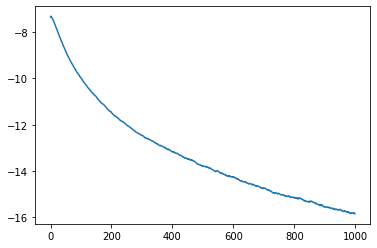

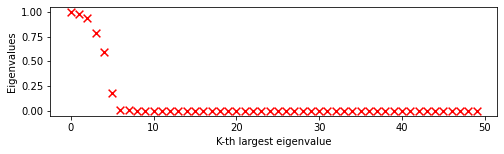

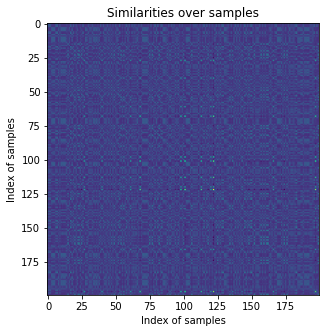

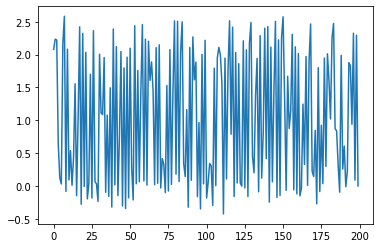

3.295131126682243
2000 -18.528579711914062


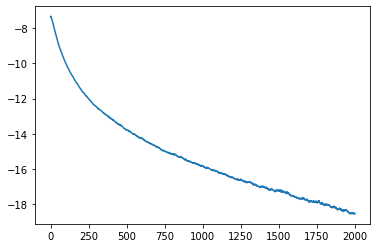

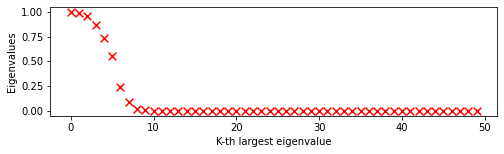

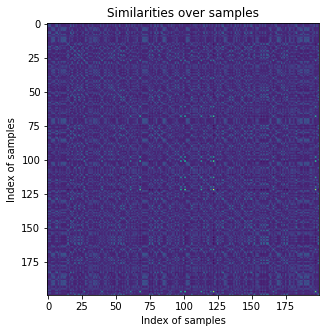

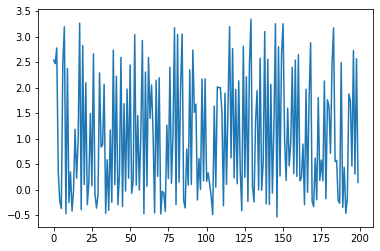

2.8947192169105675
3000 -20.647171020507812


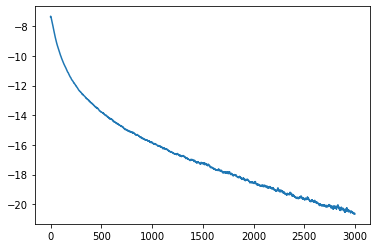

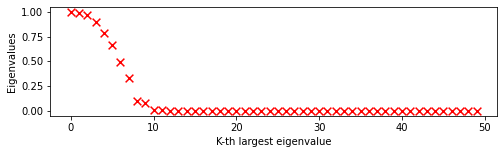

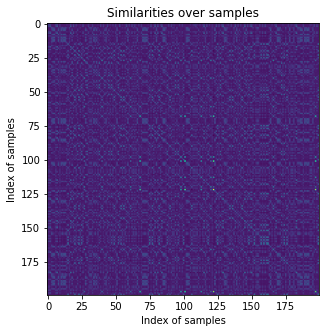

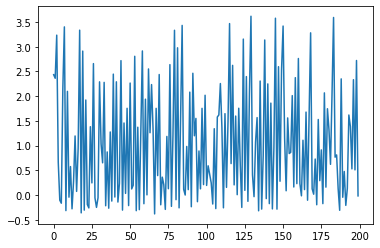

2.5013186113772017
4000 -22.468826293945312


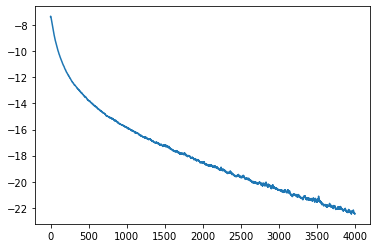

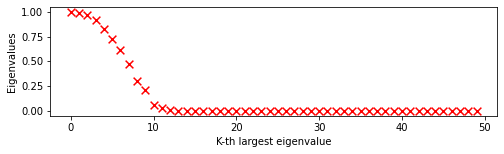

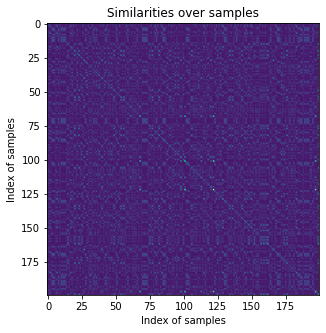

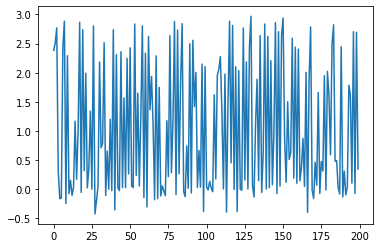

2.3968344886068818
5000 -23.827606201171875


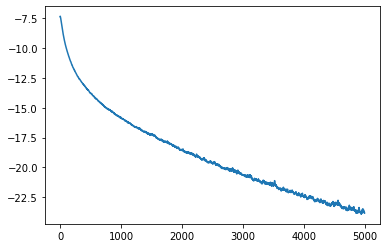

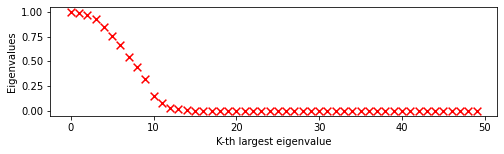

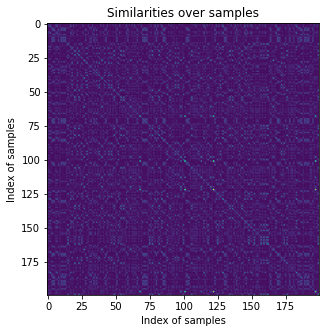

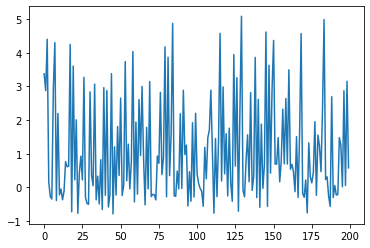

2.331066749336756
6000 -25.185195922851562


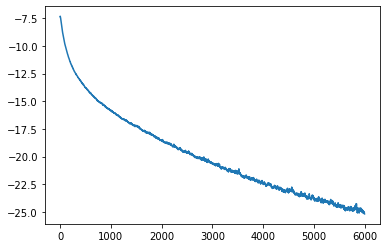

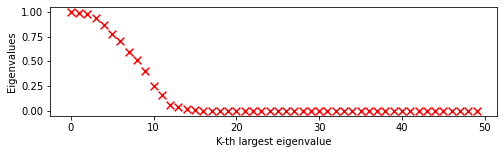

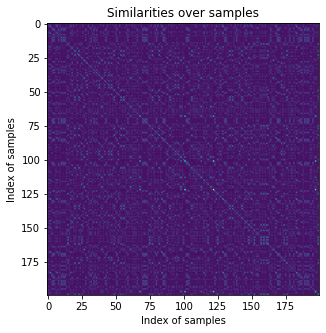

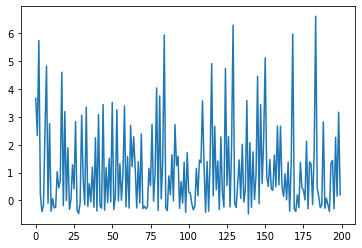

2.172480371894947
7000 -26.06097412109375


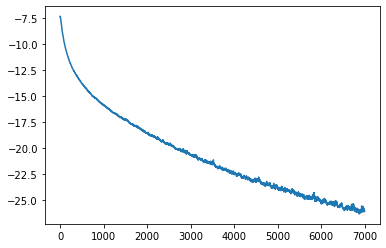

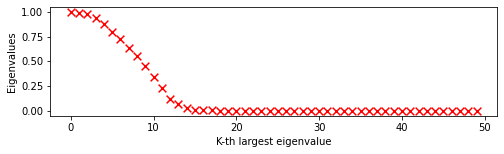

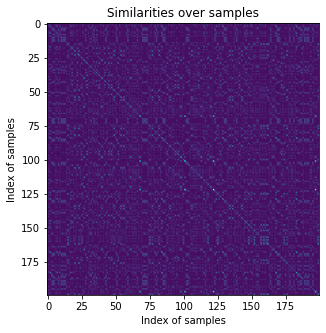

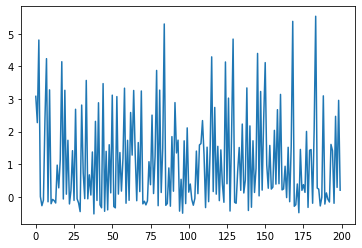

2.075882365225486
8000 -27.175048828125


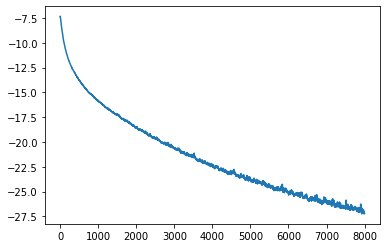

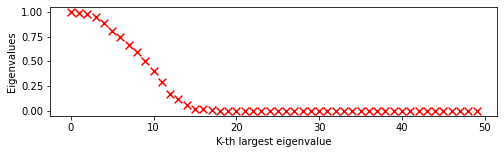

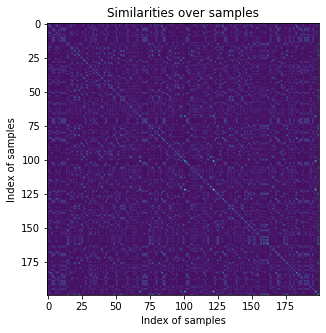

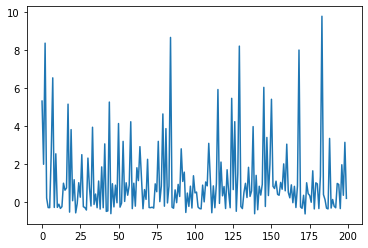

2.0392622148854915
9000 -27.769607543945312


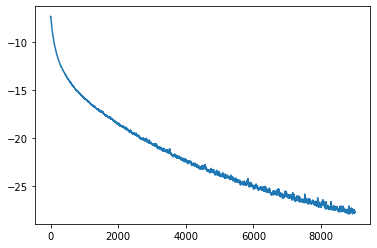

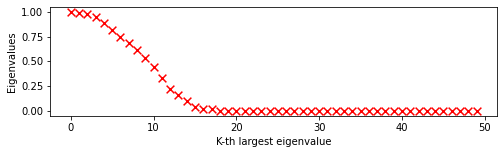

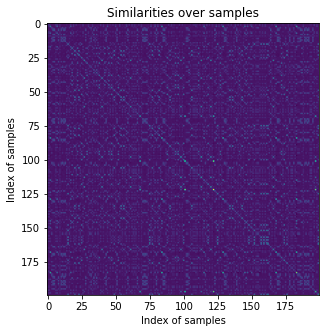

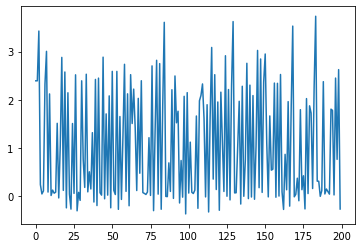

2.1245847875070054
10000 -28.594757080078125


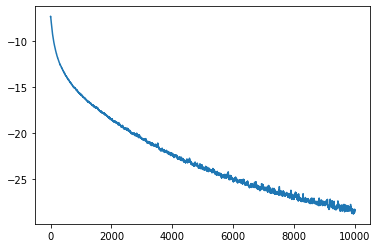

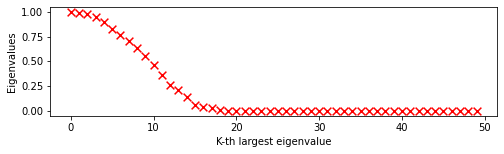

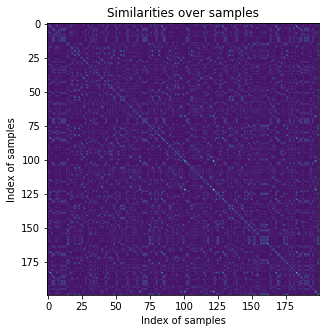

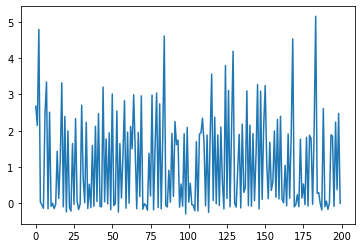

2.011425771867258
11000 -29.212356567382812


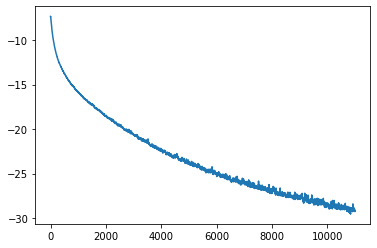

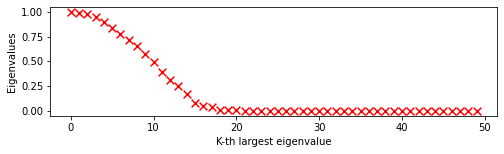

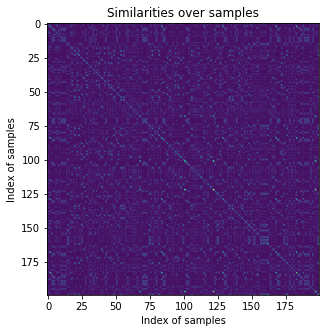

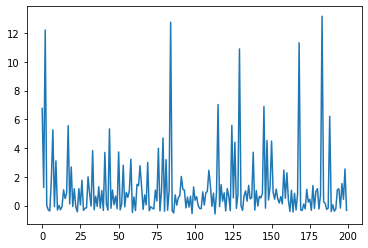

1.8402531271138232
12000 -29.86529541015625


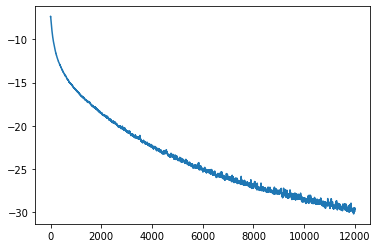

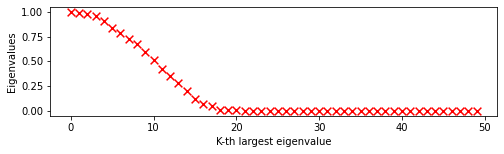

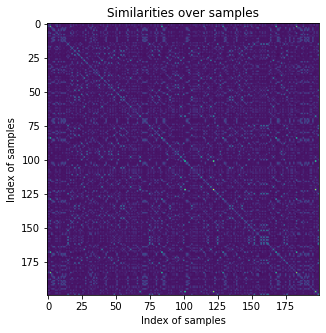

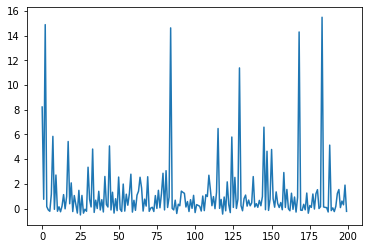

1.841286159206099
13000 -29.906005859375


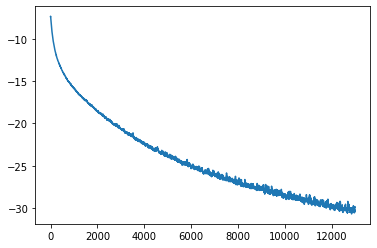

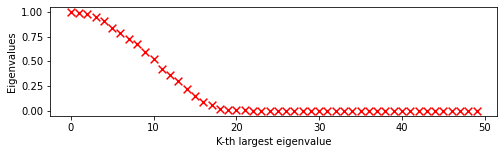

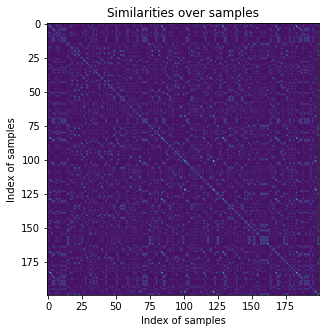

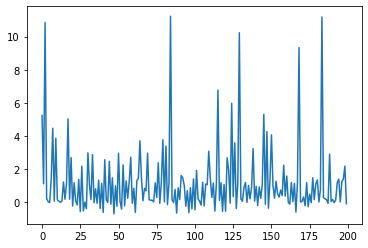

1.8639963348538973
14000 -31.20654296875


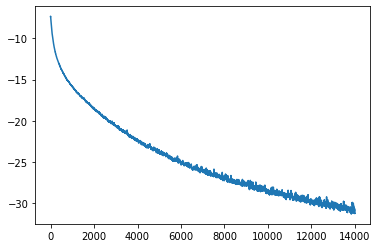

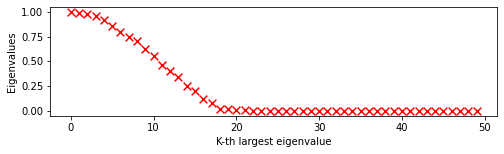

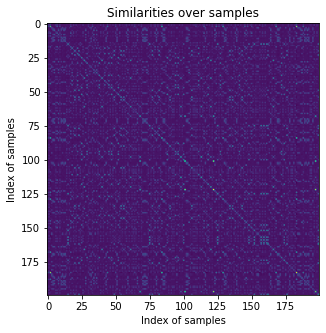

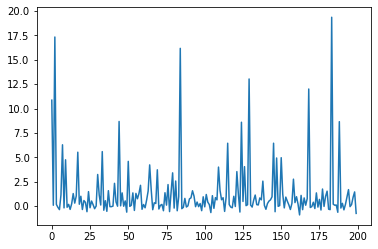

1.6940418037508307
15000 -31.391921997070312


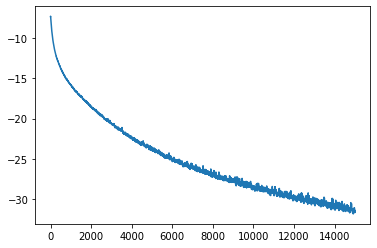

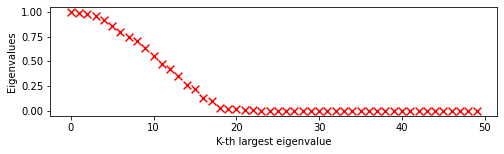

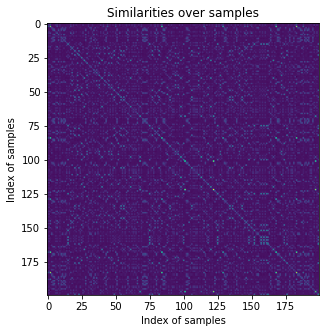

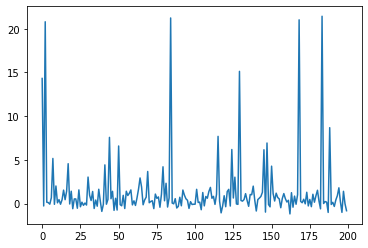

1.6254556868771899
16000 -31.675399780273438


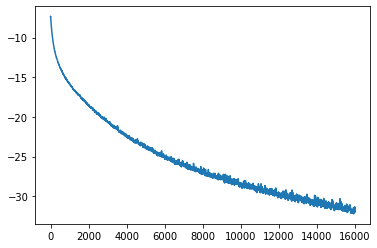

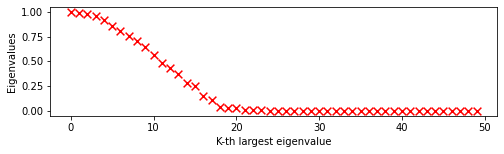

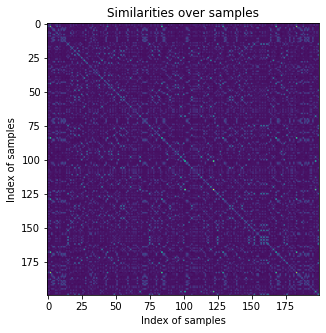

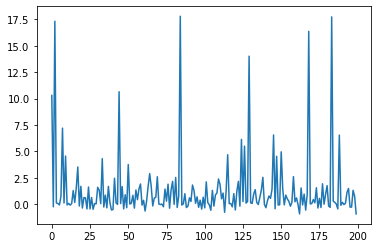

1.430315153359713
17000 -32.699615478515625


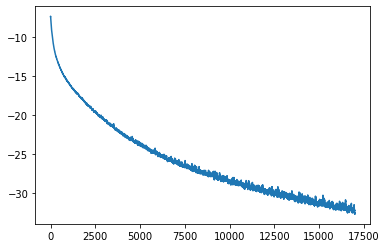

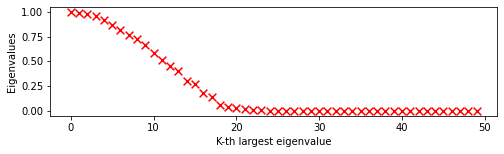

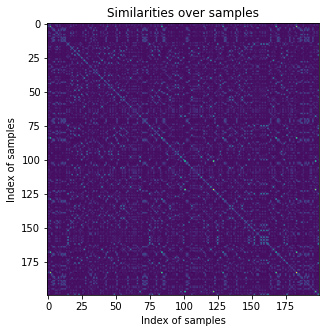

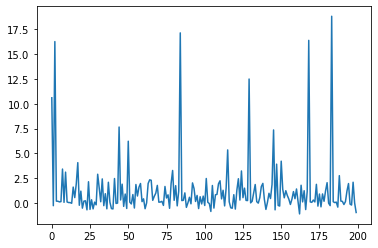

1.4002373608075047
18000 -33.04229736328125


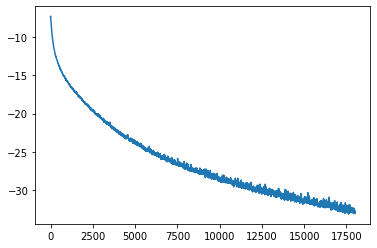

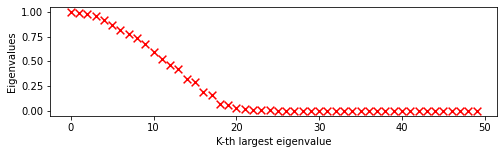

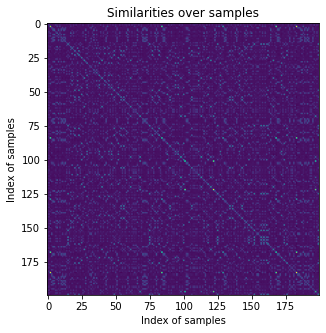

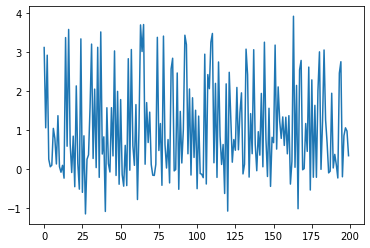

1.5085353583108592
19000 -33.17120361328125


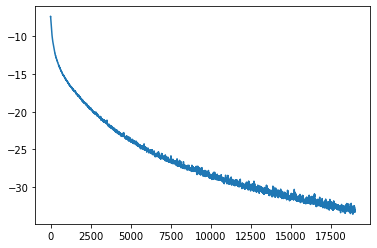

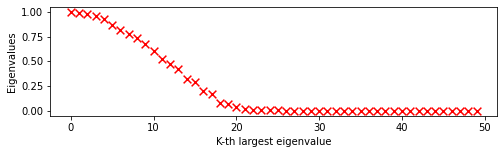

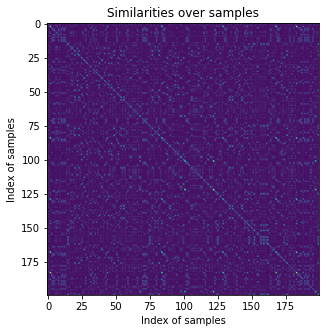

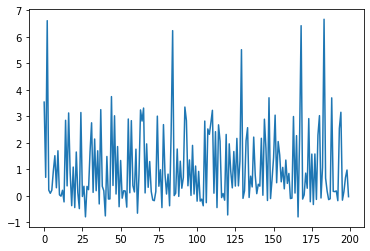

1.4596951501795363
20000 -33.43867492675781


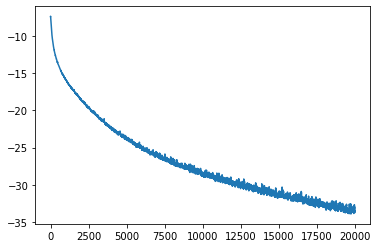

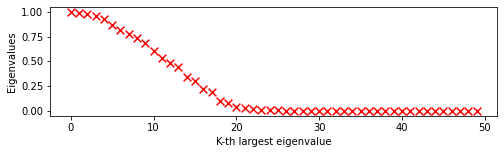

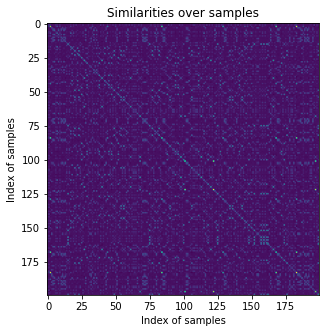

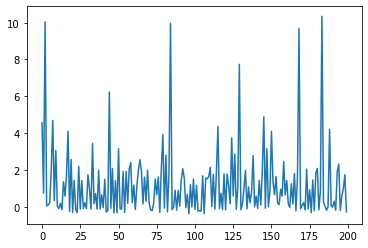

1.282105572626792
21000 -33.66705322265625


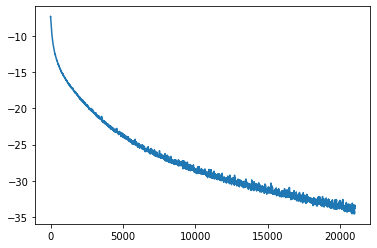

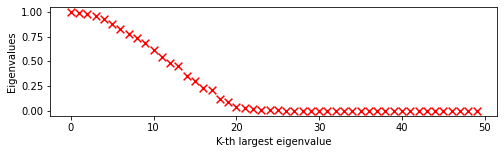

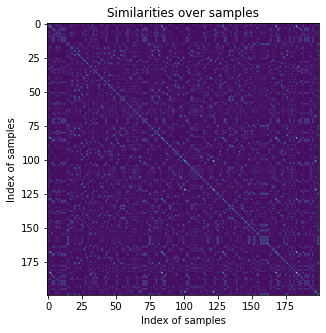

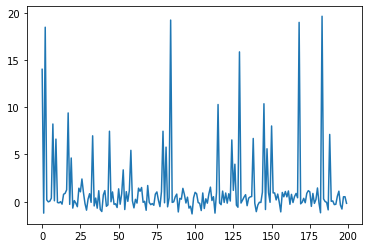

1.176286495264054
22000 -34.31764221191406


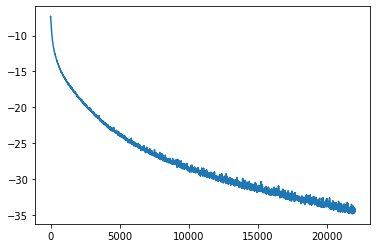

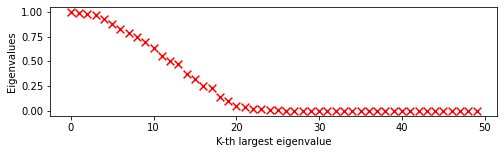

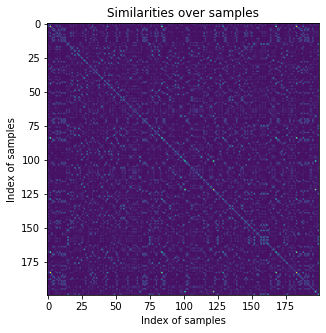

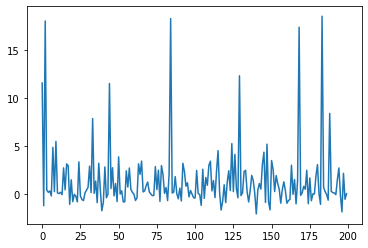

1.206774462261132
23000 -34.7099609375


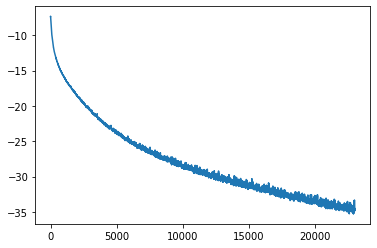

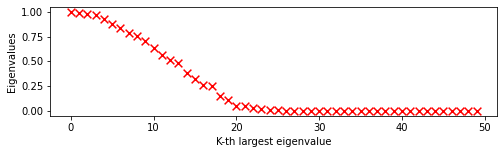

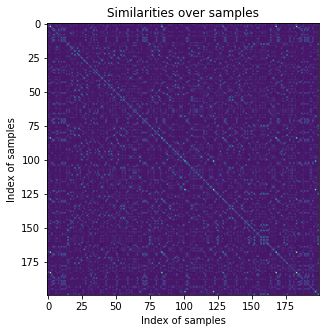

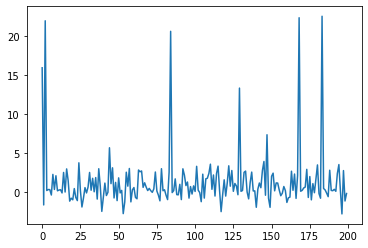

1.1102957836817544
24000 -35.46795654296875


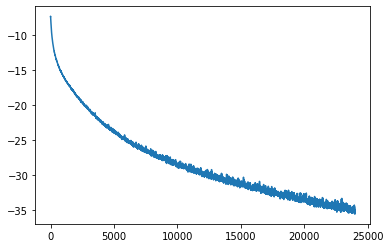

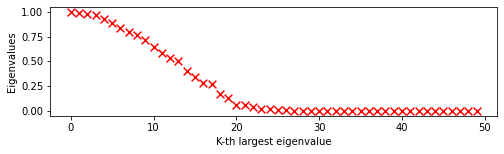

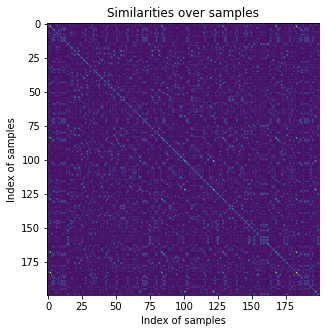

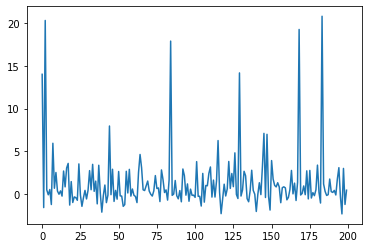

1.1798303699525579
25000 -35.35121154785156


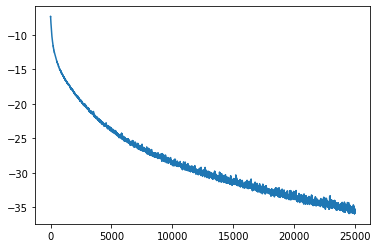

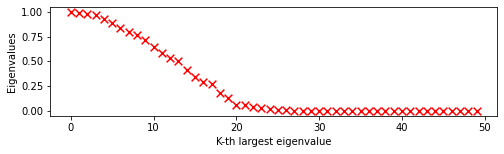

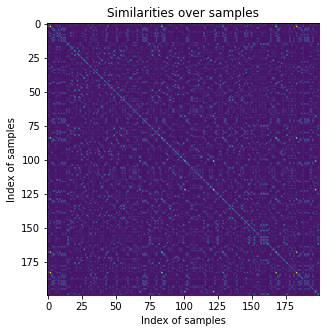

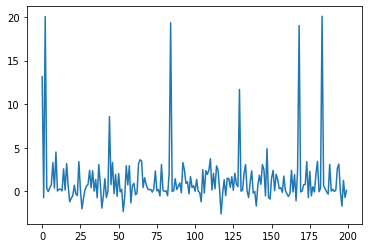

1.078765414875053
26000 -35.619415283203125


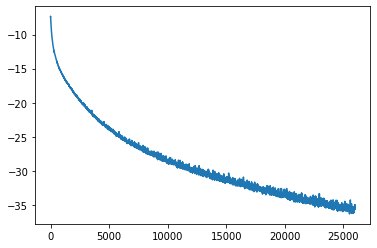

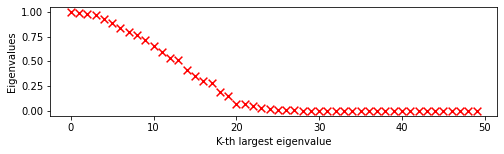

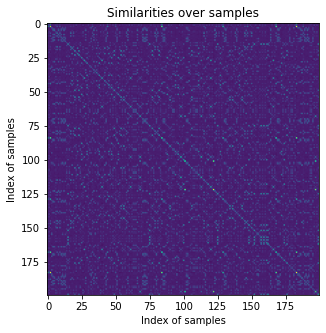

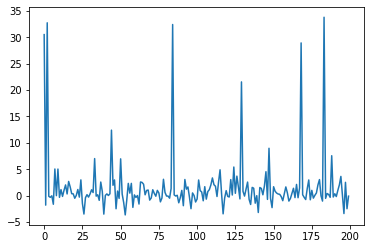

0.9672076485140415
27000 -36.29017639160156


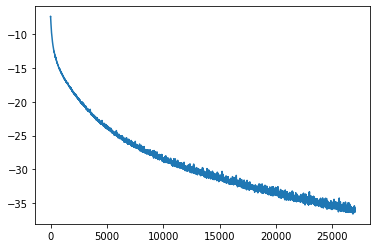

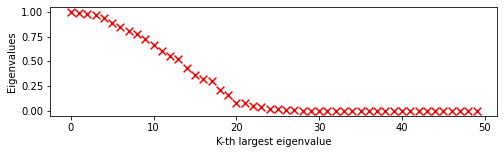

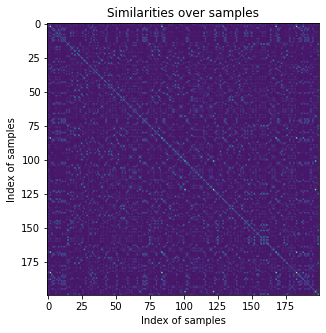

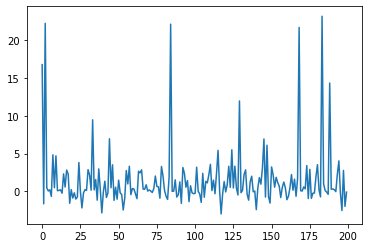

0.8604654450775722
28000 -36.56901550292969


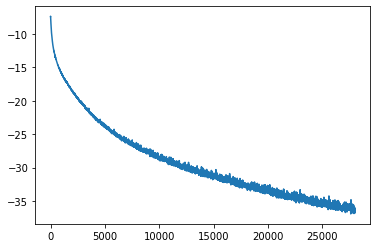

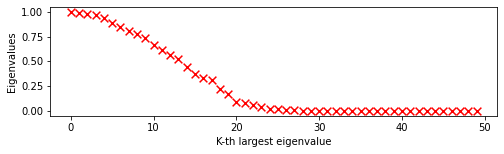

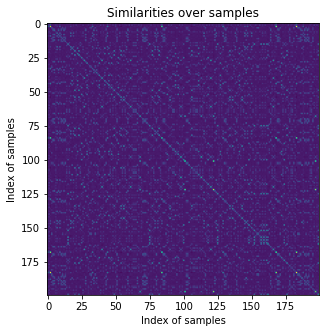

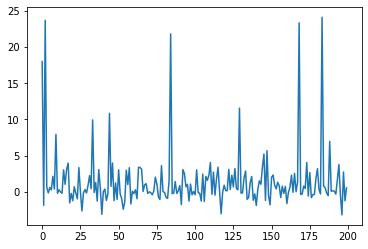

0.9005566522143497
29000 -36.56048583984375


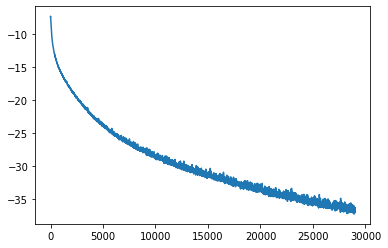

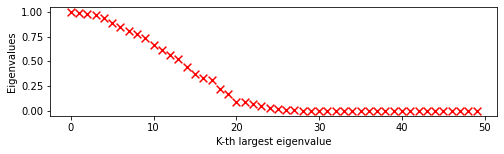

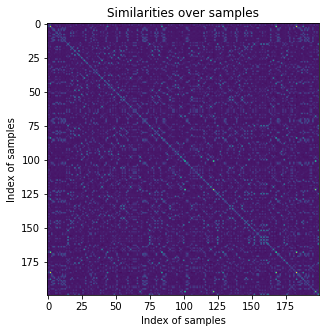

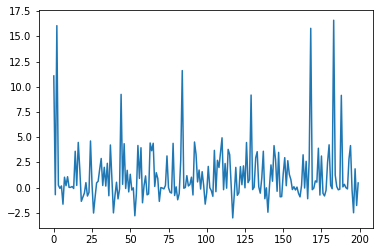

1.0416939600102124


In [ ]:
torch.cuda.set_device(0)

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

units_f = 50
units_g = 50
how_many_layers = 3

track_cov0 = torch.zeros((units_f + units_g, units_f + units_g)).cuda()

NET_F = NETWORK_F_MLP(input_dim = SAMPLE_X.shape[1], HIDDEN = 300, out_dim = units_f, how_many_layers = how_many_layers).cuda()
NET_G = NETWORK_F_MLP(input_dim = SAMPLE_Y.shape[1], HIDDEN = 300, out_dim = units_g, how_many_layers = how_many_layers).cuda()

beta1 = 0.9
beta2 = 0.999

lr1 = 0.00001
lr2 = 0.00001

optimizer_f = optim.Adam([
      {'params': NET_F.parameters(), 'lr': lr2, 'betas': (beta1, beta2)},
   ], amsgrad = True, weight_decay=0)

optimizer_g = optim.Adam([
      {'params': NET_G.parameters(), 'lr': lr2, 'betas': (beta1, beta2)},
   ], amsgrad = True, weight_decay=0)

# TRAIN G DECODER

j = 0
bs = 3000

save_curve = []
error_list = []

eig_list = []

jump = 1
for i in range(1, 30000):
    b1 = np.random.choice(SAMPLE_X[::jump].shape[0], bs)

    sampled_data = SAMPLE_X[b1, :].float().cuda()
    sampled_noise = SAMPLE_Y[b1, :].float().cuda()

    output_f = NET_F(sampled_data)
    output_g = NET_G(sampled_noise)

    cat_vector = torch.cat((output_f, output_g), 1)
    cov_estimate, cov, track_cov0 = produce_CC_GRAD_ALL(cat_vector, track_cov0, i)

    cov_estimate_f = cov_estimate[:units_f, :units_f]
    cov_f = cov[:units_f, :units_f]

    cov_estimate_g = cov_estimate[units_f:, units_f:]
    cov_g = cov[units_f:, units_f:]

    LOSS = (torch.linalg.inv(cov_estimate)*cov).sum() - (torch.linalg.inv(cov_estimate_f)*cov_f).sum() - (torch.linalg.inv(cov_estimate_g)*cov_g).sum()
    (LOSS).backward()

    optimizer_g.step()
    optimizer_f.step()

    optimizer_g.zero_grad()
    optimizer_f.zero_grad()

    COST = torch.logdet(cov_estimate) - torch.logdet(cov_estimate_f) - torch.logdet(cov_estimate_g)
    save_curve.append(COST.item())

#     end_lr = 0
#     optimizer_f.param_groups[0]['lr'] = (lr2*(200000-i) + end_lr*(i))/200000
#     optimizer_g.param_groups[0]['lr'] = (lr2*(200000-i) + end_lr*(i))/200000

#     optimizer_f.param_groups[0]['lr'] = np.exp((np.log(lr2)*(100000-i) + np.log(1e-7)*(i))/100000)
#     optimizer_g.param_groups[0]['lr'] = np.exp((np.log(lr2)*(100000-i) + np.log(1e-7)*(i))/100000)

#     error = print_f_error()
#     error_list.append(error)

#           print('Eigen:', eig)

    if i%1000 == 0 or i==1:
        COST = torch.logdet(cov_estimate) - torch.logdet(cov_estimate_f) - torch.logdet(cov_estimate_g)
        print(i, COST.item())

        plt.plot(save_curve)
        plt.show()

        from scipy.linalg import fractional_matrix_power

        save_cov_1 = np.copy(cov_estimate.detach().cpu().numpy())
        normalize = np.zeros((save_cov_1.shape))

        cov_1 = save_cov_1[:units_f, :units_f]
        cov_2 = save_cov_1[units_f:, units_f:]

        normalize[:units_f, :units_f] = (cov_1)
        normalize[units_f:, units_f:] = (cov_2)

        normalize_fmp = fractional_matrix_power(normalize, -0.5)
        grad = normalize_fmp@save_cov_1@normalize_fmp

        PPT = grad[:units_f, units_f:]@grad[:units_f, units_f:].T
        PPT = PPT

        eig = np.abs(np.linalg.eig(PPT)[0])
        eig.sort()
        eig_list.append(eig)

#         plt.plot(eig_list)
# #         for k in range(0, 10):
# #             plt.axhline(eigen_values[k], color='r', linestyle='--', linewidth=1)

#         plt.title('Eigenvalues')
#         plt.ylabel('Eigenvalues')
#         plt.xlabel('Iterations')
#         plt.show()

#         plt.title('Frobenius Norm $||\mathbf{P}\mathbf{v} - \Lambda\mathbf{v}\||_F$')
#         plt.ylabel('Matrix norm')
#         plt.xlabel('Iterations')
#         plt.plot(error_list)
#         plt.yscale('log')
#         plt.show()

#         NET_F.eval()
# #         output_f = NET_F(x_inter.cuda().float()).detach().cpu().numpy()
# #         plt.plot(output_f[:])

#         learned_f, eigv = print_f_eigenvector()

# #         plt.plot(np.linspace(-6, 6, 1000), learned_f)
# #         plt.title('Eigenfunctions')
# #         plt.ylabel('Values of the function')
# #         plt.xlabel('Iterations')
# #         plt.show()

#         filtered_f = p_x_given_y_over_domain@learned_f/1000

#         plt.plot(filtered_f*10)
#         plt.show()

#         plt.plot(learned_f*p_x.reshape(-1, 1)*eigv.reshape(1, -1))
#         plt.show()

#         plt.scatter(np.arange(0, 20), eigen_values[::-1][:20]/eigen_values.max(), color='green', marker='.', s=100)
#         plt.scatter(np.arange(0, units_f), eig_list[-1][::-1], color='red', marker='x', s=100)
#         plt.xlabel('K-th largest eigenvalue')
#         plt.ylabel('Eigenvalues')
#         plt.xticks([0, 2, 4, 6 ,8 ,10, 12, 14, 16, 18, 20])
#         plt.show()

#         plt.scatter(np.arange(0, units_f), eig_list[-1][::-1], color='red', marker='x', s=10)
#         plt.xlabel('K-th largest eigenvalue')
#         plt.ylabel('Eigenvalues')
#         plt.xticks([0, 2, 4, 6 ,8 ,10, 12, 14, 16, 18])

        plt.figure(figsize=(8, 2))
        plt.scatter(np.arange(0, units_f), eig_list[-1][::-1][:units_f], color='red', marker='x', s=60)
        plt.xlabel('K-th largest eigenvalue')
        plt.ylabel('Eigenvalues')
        plt.show()

        learned_f, eigv = print_f_eigenvector_mnist()

        plt.figure(figsize=(5, 5))

        check_similarity = learned_f[::10]
        similarity = check_similarity*eigv.reshape(1, -1)@check_similarity.T
        plt.imshow(similarity)
        plt.title('Similarities over samples')
        plt.xlabel('Index of samples')
        plt.ylabel('Index of samples')
        plt.show()

        plt.plot(similarity[:, 0])
        plt.show()

        NET_F.train()


        layer_f = wf_layer_WIENERSOLUTION(learned_f.shape[0])
        layer_f.train(learned_f, desired[::10].reshape(-1))
        predict = layer_f.forward((learned_f))
        error = np.mean((desired[::10].reshape(-1) - predict.reshape(-1))**2)
        print(error)


In [ ]:
def print_f_eigenvector_mnist():

    input_ = SAMPLE_X[::100]

    BS = 1
    output_f = np.zeros((BS, input_.shape[0], units_f))
    for k in range(0, BS):
        output_f[k] = NET_F(input_.cuda().float()).detach().cpu().numpy()
    output_f = output_f.mean(0)
    var_f = output_f.var(0)

#     plt.plot(output_f[::10])
#     plt.show()

    normalized_f = output_f
#     normalized_f = output_f - output_f.mean(0)
    normalized_f = normalized_f@normalize_fmp[:units_f, :units_f]

#     normalized_f = normalized_f.reshape(10, 10, 10).mean(1)

    grad_matrix = grad[:units_f, units_f:]@grad[:units_f, units_f:].T

    # grad_matrix = np.linalg.inv(grad_matrix)
    eig = np.abs(np.linalg.eig(grad_matrix)[0])
    eig_vec = np.linalg.eig(grad_matrix)[1]

    constructed_value = eig
    constructed_vector = (eig_vec.T@normalized_f.T).T

    return constructed_vector, constructed_value

constructed_vector, constructed_value = print_f_eigenvector_mnist()

In [ ]:
check_similarity = learned_f[::1]
similarity = check_similarity*eigv.reshape(1, -1)@check_similarity.T

In [ ]:
similarity.shape

NameError: ignored

In [ ]:
layer_f = wf_layer_WIENERSOLUTION(similarity.shape[0])
layer_f.train(similarity, desired[::10].reshape(-1))
predict = layer_f.forward((similarity))
error = np.mean((desired[::10].reshape(-1) - predict.reshape(-1))**2)
print(error)

1.0430843499521307


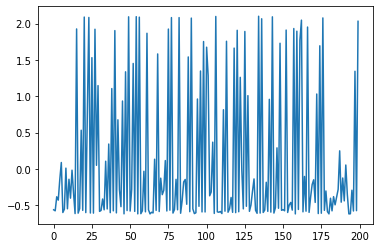

In [ ]:
plt.plot(learned_f[::10, 1])
plt.show()

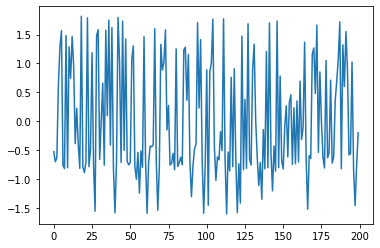

In [ ]:
plt.plot(learned_f[::10, 2])
plt.show()

In [ ]:
class wf_layer_WIENERSOLUTION():
    def __init__(self, N):
        self.weights = None

    def forward(self, x):
        x_ = np.concatenate((np.ones((x.shape[0], 1)), x), 1)

        return self.weights@x_.T

    def train(self, x, desire_list):

        x_ = np.concatenate((np.ones((x.shape[0], 1)), x), 1)
        self.weights = desire_list.T@x_@np.linalg.pinv(x_.T@x_)
        return (x_.T@x_), desire_list.T@x_

layer_f = wf_layer_WIENERSOLUTION(learned_f.shape[0])
layer_f.train(learned_f, desired[::10].reshape(-1))
predict = layer_f.forward((learned_f))
error = np.mean((desired[::10].reshape(-1) - predict.reshape(-1))**2)
print(error)
# output = net(torch.from_numpy(x_list).float().cuda()).cpu().data.numpy()
# layer_f = wf_layer_WIENERSOLUTION(output.shape[0])
# layer_f.train((output), label_list.reshape(-1))
# predict = layer_f.forward((output))

# #type_1_list.append(compute_E_QMI_type1(np.sum(output, 1), DESIRE, batch_size = 400))
# #type_2_list.append(compute_E_QMI_type2(np.sum(output, 1), DESIRE, batch_size = 400))

# error = np.mean((label_list.reshape(-1) - predict.reshape(-1))**2)
# second_module_loss.append(error)

1.0416939600102124


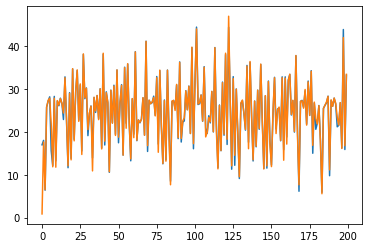

In [ ]:
plt.plot(predict[::10])
plt.plot(desired[::10][::10])
plt.show()

In [ ]:
learned_f.shape

(2000, 50)

In [ ]:
def print_f_eigenvector_signal(train_data):

    input_ = torch.from_numpy(train_data)

    BS = 1
    output_f = np.zeros((BS, input_.shape[0], units_f))
    for k in range(0, BS):
        output_f[k] = NET_F(input_.cuda().float()).detach().cpu().numpy()
    output_f = output_f.mean(0)
    var_f = output_f.var(0)

#     plt.plot(output_f[::10])
#     plt.show()

    normalized_f = output_f
#     normalized_f = output_f - output_f.mean(0)
    normalized_f = normalized_f@normalize_fmp[:units_f, :units_f]

#     normalized_f = normalized_f.reshape(10, 10, 10).mean(1)

    grad_matrix = grad[:units_f, units_f:]@grad[:units_f, units_f:].T

    # grad_matrix = np.linalg.inv(grad_matrix)
    eig = np.abs(np.linalg.eig(grad_matrix)[0])
    eig_vec = np.linalg.eig(grad_matrix)[1]

    constructed_value = eig
    constructed_vector = (eig_vec.T@normalized_f.T).T

    return constructed_vector, constructed_value